<center><b><font size=6>Language Models exploration<b><center>

This notebook focuses on experimenting with language models to solve the same supervised task as discussed in Section 2. The primary objective is to leverage the capabilities of advanced language models such as **BERT** or **Doc2Vec** for supervised learning tasks—specifically, assigning intents to sessions. 

### Key Concepts:
1. **Transfer Learning**:
   - Use a model pre-trained on vast datasets by tech companies.
   - Fine-tune this model on a smaller, domain-specific dataset for improved performance.

2. **Vector Encoding in NLP**:
   - Words or documents are transformed into vectors (encoding) through an **unsupervised process**.
   - This approach allows the use of significantly larger datasets during the training phase.

### Experiment Steps:
1. **Model Selection**:
   - Choose between **BERT** and **Doc2Vec**:
     - **Doc2Vec**: Pretrain on the session text's `body` column.
     - **BERT**: Use a pre-trained model, such as `BertForSequenceClassification` or another implementation from HuggingFace.

2. **Add a Dense Layer**:
   - Extend the model with a custom dense (fully connected) layer for the classification task.

3. **Fine-Tuning**:
   - Fine-tune the last layer of the network on the supervised training dataset for a fixed number of epochs.

4. **Plot Learning Curves**:
   - Visualize the training and validation loss curves.
   - Identify the optimal stopping point for training (early stopping based on validation performance).

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section4

Installing common packages: pandas, pyarrow
  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device: '/opt/conda/lib/python3.7/site-packages/pyarrow'

Error installing package pyarrow: Command '['/opt/conda/bin/python', '-m', 'pip', 'install', 'pyarrow']' returned non-zero exit status 1.


In [1]:
import os
import time
import numpy as np
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler

from collections import Counter

from tqdm import tqdm

<center><b><font size=5>Training<b><center>

In [2]:
# Paths for saving preprocessed data
TOKENIZED_TRAIN_PATH = "../data/processed/train_encodings.pkl"
TOKENIZED_VAL_PATH = "../data/processed/val_encodings.pkl"

In [3]:
# Load Dataset
print("Loading the dataset...")
df = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
print(f"Dataset loaded successfully with {df.shape[0]} rows.")

Loading the dataset...
Dataset loaded successfully with 233035 rows.


In [4]:
# Flatten the lists in 'full_session' and count word occurrences
all_words = [word for session in df['full_session'] for word in session]
word_counts = Counter(all_words)

# Define a threshold (e.g., words must appear in at least 2 lists)
threshold = 2300
frequent_words = {word for word, count in word_counts.items() if count >= threshold}

# Filter each list in 'full_session'
df['full_session'] = df['full_session'].apply(
    lambda session: [word for word in session if word in frequent_words]
)

In [5]:
df['full_session'].explode().unique().shape

(126,)

In [5]:
# Preprocess the 'Set_Fingerprint' column for multi-label encoding
print("Preprocessing 'Set_Fingerprint' column...")
df['Set_Fingerprint'] = df['Set_Fingerprint'].apply(lambda x: [intent.strip() for intent in x])

# Apply MultiLabelBinarizer for encoding
print("Applying MultiLabelBinarizer for encoding...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Set_Fingerprint'])
print(f"Classes identified: {mlb.classes_}")

Preprocessing 'Set_Fingerprint' column...
Applying MultiLabelBinarizer for encoding...
Classes identified: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


In [30]:
# Split data into 90% for training and validation, and 10% for testing
print("Splitting the data into training, validation, and testing sets...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['full_session'], y, test_size=0.2, random_state=42
)

# Split the remaining 90% into 70% for training and 20% for validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2
)
print("Data split complete.")

Splitting the data into training, validation, and testing sets...
Data split complete.


In [31]:
# Define utility functions for saving and loading tokenized data
def save_tokenized_data(filepath, data):
    """
    Save tokenized data to a file.
    :param filepath: Path to save the data.
    :param data: Tokenized data to be saved.
    """
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data successfully saved to {filepath}")

def load_tokenized_data(filepath):
    """
    Load tokenized data from a file.
    :param filepath: Path to load the data from.
    :return: Loaded tokenized data.
    """
    with open(filepath, 'rb') as f:
        print(f"Data successfully loaded from {filepath}")
        return pickle.load(f)

In [32]:
# Tokenization with Save/Load Mechanism
print("Loading or performing tokenization...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

TOKENIZED_TRAIN_PATH = "../data/processed/train_encodings.pkl"
TOKENIZED_VAL_PATH = "../data/processed/val_encodings.pkl"
TOKENIZED_TEST_PATH = "../data/processed/test_encodings.pkl"

if os.path.exists(TOKENIZED_TRAIN_PATH) and os.path.exists(TOKENIZED_VAL_PATH) and os.path.exists(TOKENIZED_TEST_PATH):
    print("Pre-tokenized data found. Loading...")
    train_encodings = load_tokenized_data(TOKENIZED_TRAIN_PATH)
    val_encodings = load_tokenized_data(TOKENIZED_VAL_PATH)
    test_encodings = load_tokenized_data(TOKENIZED_TEST_PATH)
else:
    print("Pre-tokenized data not found. Performing tokenization...")
    train_texts_cleaned = list(train_texts.fillna("").astype(str))
    val_texts_cleaned = list(val_texts.fillna("").astype(str))
    test_texts_cleaned = list(test_texts.fillna("").astype(str))

    train_encodings = tokenizer(
        train_texts_cleaned,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt",
    )
    val_encodings = tokenizer(
        val_texts_cleaned,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt",
    )
    test_encodings = tokenizer(
        test_texts_cleaned,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt",
    )

    save_tokenized_data(TOKENIZED_TRAIN_PATH, train_encodings)
    save_tokenized_data(TOKENIZED_VAL_PATH, val_encodings)
    save_tokenized_data(TOKENIZED_TEST_PATH, test_encodings)
    print("Tokenization complete and data saved.")

Loading or performing tokenization...
Pre-tokenized data found. Loading...
Data successfully loaded from ../data/processed/train_encodings.pkl
Data successfully loaded from ../data/processed/val_encodings.pkl
Data successfully loaded from ../data/processed/test_encodings.pkl


In [33]:
class SSHDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx].clone().detach(),
            'attention_mask': self.encodings['attention_mask'][idx].clone().detach(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

    def __len__(self):
        return len(self.labels)

In [34]:
# Initialize DataLoaders
print("Initializing DataLoaders...")
train_dataset = SSHDataset(train_encodings, train_labels)
val_dataset = SSHDataset(val_encodings, val_labels)
test_dataset = SSHDataset(test_encodings, test_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
    prefetch_factor=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
    prefetch_factor=2
)

print(f"Train DataLoader: {len(train_loader)} batches ready.")
print(f"Validation DataLoader: {len(val_loader)} batches ready.")
print(f"Test DataLoader: {len(test_loader)} batches ready.")


Initializing DataLoaders...
Train DataLoader: 8739 batches ready.
Validation DataLoader: 2913 batches ready.
Test DataLoader: 2913 batches ready.


In [35]:
# Initialize the model
print("Initializing the BERT model for sequence classification...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class CustomBERTModel(torch.nn.Module):
    def __init__(self, bert_model, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        self.classifier = torch.nn.Linear(bert_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

model = CustomBERTModel(bert_model, num_labels=y.shape[1])
model.to(device)

model = torch.compile(model)

Initializing the BERT model for sequence classification...


In [36]:
# Optimizer, Scheduler, and Mixed Precision Training
optimizer = AdamW(model.parameters(), lr=4e-5, betas=(0.9, 0.98), eps=1e-6)
num_training_steps = len(train_loader) * 10
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = GradScaler()

/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_6029/1347050389.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Fine-tuning of the model

In [37]:
# Training loop
print("Starting the training process...")
train_loss_list, val_loss_list = [], []
y_pred_probs_per_epoch = []
epochs = 4
accumulation_steps = 4

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    epoch_pred_probs = []

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch + 1}", unit="batch") as pbar:
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                logits = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
                loss = criterion(logits, batch['labels'].to(device)) / accumulation_steps
                scaler.scale(loss).backward()
                epoch_pred_probs.append(torch.sigmoid(logits).cpu().detach().numpy())

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

            total_loss += loss.item()
            pbar.update(1)

    epoch_train_loss = total_loss / len(train_loader)
    train_loss_list.append(epoch_train_loss)
    y_pred_probs_per_epoch.append(np.vstack(epoch_pred_probs))
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Validating Epoch {epoch + 1}", unit="batch") as pbar:
            for batch in val_loader:
                with torch.cuda.amp.autocast():
                    logits = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
                    loss = criterion(logits, batch['labels'].to(device))
                    val_loss += loss.item()
                pbar.update(1)

    epoch_val_loss = val_loss / len(val_loader)
    val_loss_list.append(epoch_val_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {epoch_val_loss:.4f}")

Starting the training process...

Epoch 1/4


/tmp/ipykernel_6029/2767315215.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_6029/2767315215.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training Epoch 1: 100%|██████████████████████| 8739/8739 [11:50<00:00, 12.30batch/s]


Epoch 1 Training Loss: 0.0057


/tmp/ipykernel_6029/2767315215.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_6029/2767315215.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating Epoch 1: 100%|████████████████████| 2913/2913 [01:14<00:00, 39.07batch/s]


Epoch 1 Validation Loss: 0.0182

Epoch 2/4


/tmp/ipykernel_6029/2767315215.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training Epoch 2: 100%|██████████████████████| 8739/8739 [11:21<00:00, 12.82batch/s]


Epoch 2 Training Loss: 0.0042


Validating Epoch 2: 100%|████████████████████| 2913/2913 [01:05<00:00, 44.76batch/s]


Epoch 2 Validation Loss: 0.0163

Epoch 3/4


Training Epoch 3: 100%|██████████████████████| 8739/8739 [11:21<00:00, 12.82batch/s]


Epoch 3 Training Loss: 0.0041


Validating Epoch 3: 100%|████████████████████| 2913/2913 [01:04<00:00, 44.98batch/s]


Epoch 3 Validation Loss: 0.0165

Epoch 4/4


Training Epoch 4: 100%|██████████████████████| 8739/8739 [11:19<00:00, 12.86batch/s]


Epoch 4 Training Loss: 0.0040


Validating Epoch 4: 100%|████████████████████| 2913/2913 [01:04<00:00, 45.15batch/s]

Epoch 4 Validation Loss: 0.0164


In [38]:
# Function to evaluate the model on test data
def test_model(model, test_loader, device):
    model.eval()
    true_labels, pred_probs = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            logits = model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()

            true_labels.append(labels)
            pred_probs.append(probabilities)

    true_labels = np.vstack(true_labels)
    pred_probs = np.vstack(pred_probs)

    threshold = 0.5
    pred_labels = (pred_probs >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted'
    )
    roc_auc = roc_auc_score(true_labels, pred_probs, average='weighted', multi_class='ovr')

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }, true_labels, pred_probs

In [39]:
# Testing process setup
print("Testing the model...")
metrics, true_labels, predicted_probs = test_model(model, test_loader, device)

print("\nTest Metrics:")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

model_evaluation = {
    "true_labels": true_labels,
    "predicted_probabilities": predicted_probs,
    "train_losses": train_loss_list,
    "val_losses": val_loss_list,
    "probabilities_per_epoch": y_pred_probs_per_epoch,
    "metrics": metrics
}

Testing the model...


/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(



Test Metrics:
Precision: 0.9974
Recall: 0.9927
F1-Score: 0.9937
ROC-AUC: 0.9971


/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
with open("../data/Model/model_evaluation.pkl", "wb") as f:
    pickle.dump(model_evaluation, f)
    print("Model evaluation data saved successfully.")

Model evaluation data saved successfully.


In [46]:
# Save model weights
torch.save(model.state_dict(), "../data/Model/final_model.pth")

# Save optimizer state (optional)
torch.save(optimizer.state_dict(), "../data/Model/optimizer.pth")

# Save the training state (e.g., epoch, loss, etc.) if you need to resume training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss_list,
    'val_loss': val_loss_list,
}, "../data/Model/checkpoint.pth")

<center><b><font size=5>Plots<b><center>

In [7]:
import sys
sys.path.append("../")

from scripts.plotting_utils import plot_loss_curve, plot_roc_curves, plot_pr_curves, plot_prob_histograms, plot_3d_roc, plot_f1_scores, plot_performance_metrics
from scripts.data_storage_utils import save_plot, plot_and_save

In [8]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section4"

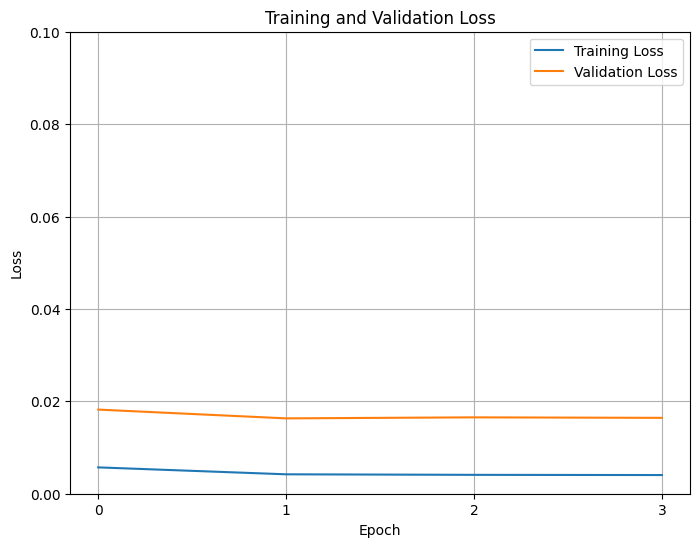

Overwriting file: '../results/figures/plots/section4/loss_curves.png'
Plot saved successfully at: '../results/figures/plots/section4/loss_curves.png'


<Figure size 640x480 with 0 Axes>

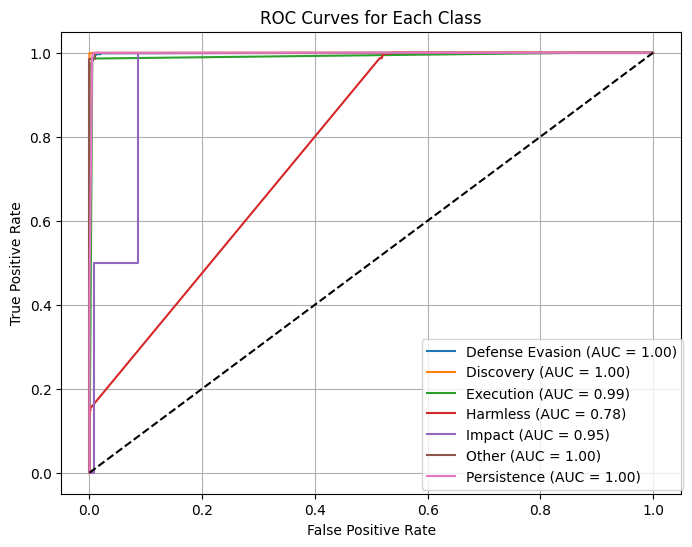

Overwriting file: '../results/figures/plots/section4/roc_curves.png'
Plot saved successfully at: '../results/figures/plots/section4/roc_curves.png'


<Figure size 640x480 with 0 Axes>

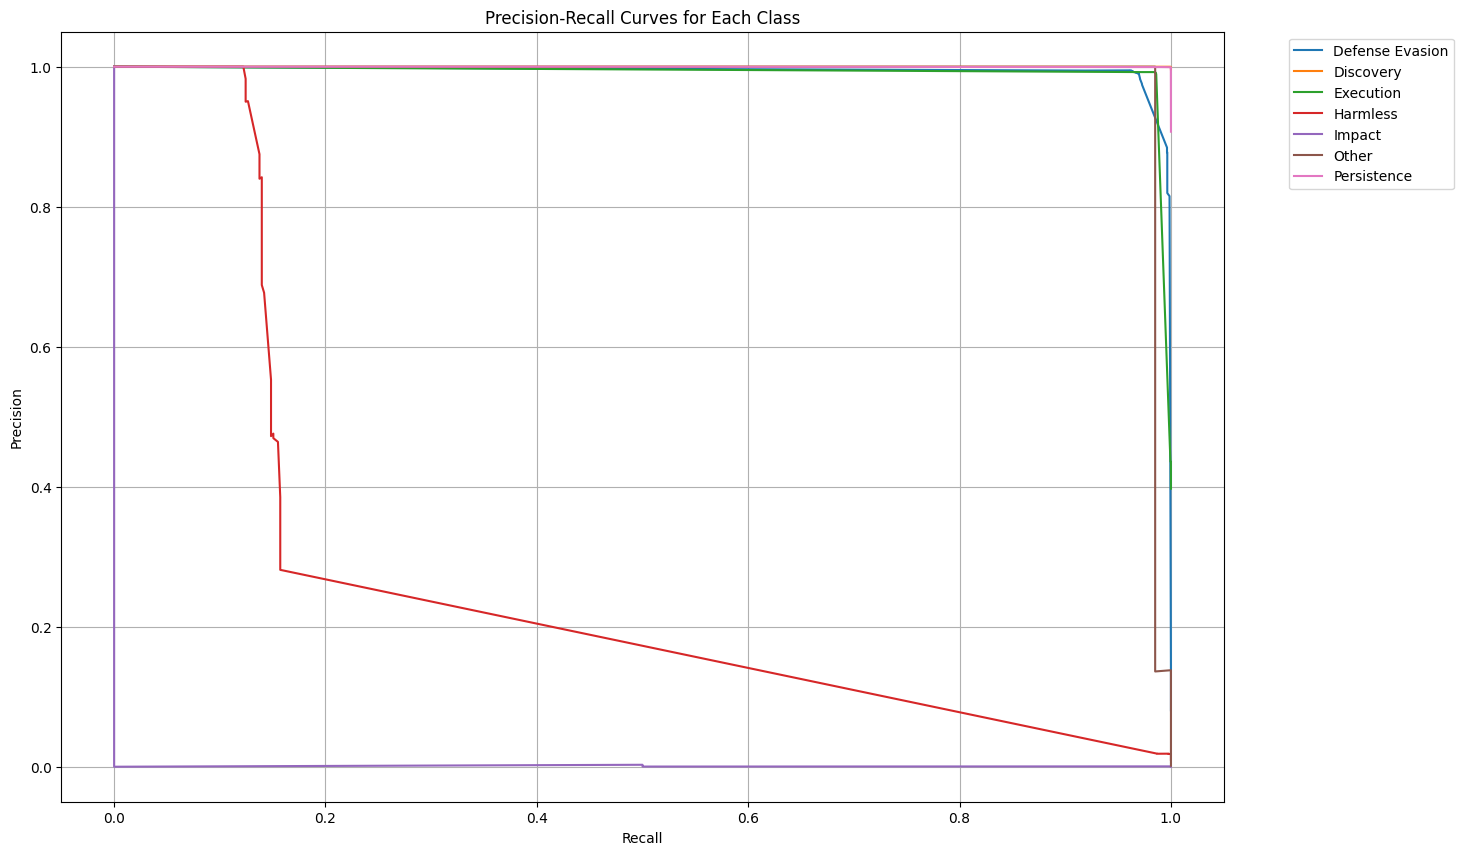

Overwriting file: '../results/figures/plots/section4/precision_recall_curves.png'
Plot saved successfully at: '../results/figures/plots/section4/precision_recall_curves.png'


<Figure size 640x480 with 0 Axes>

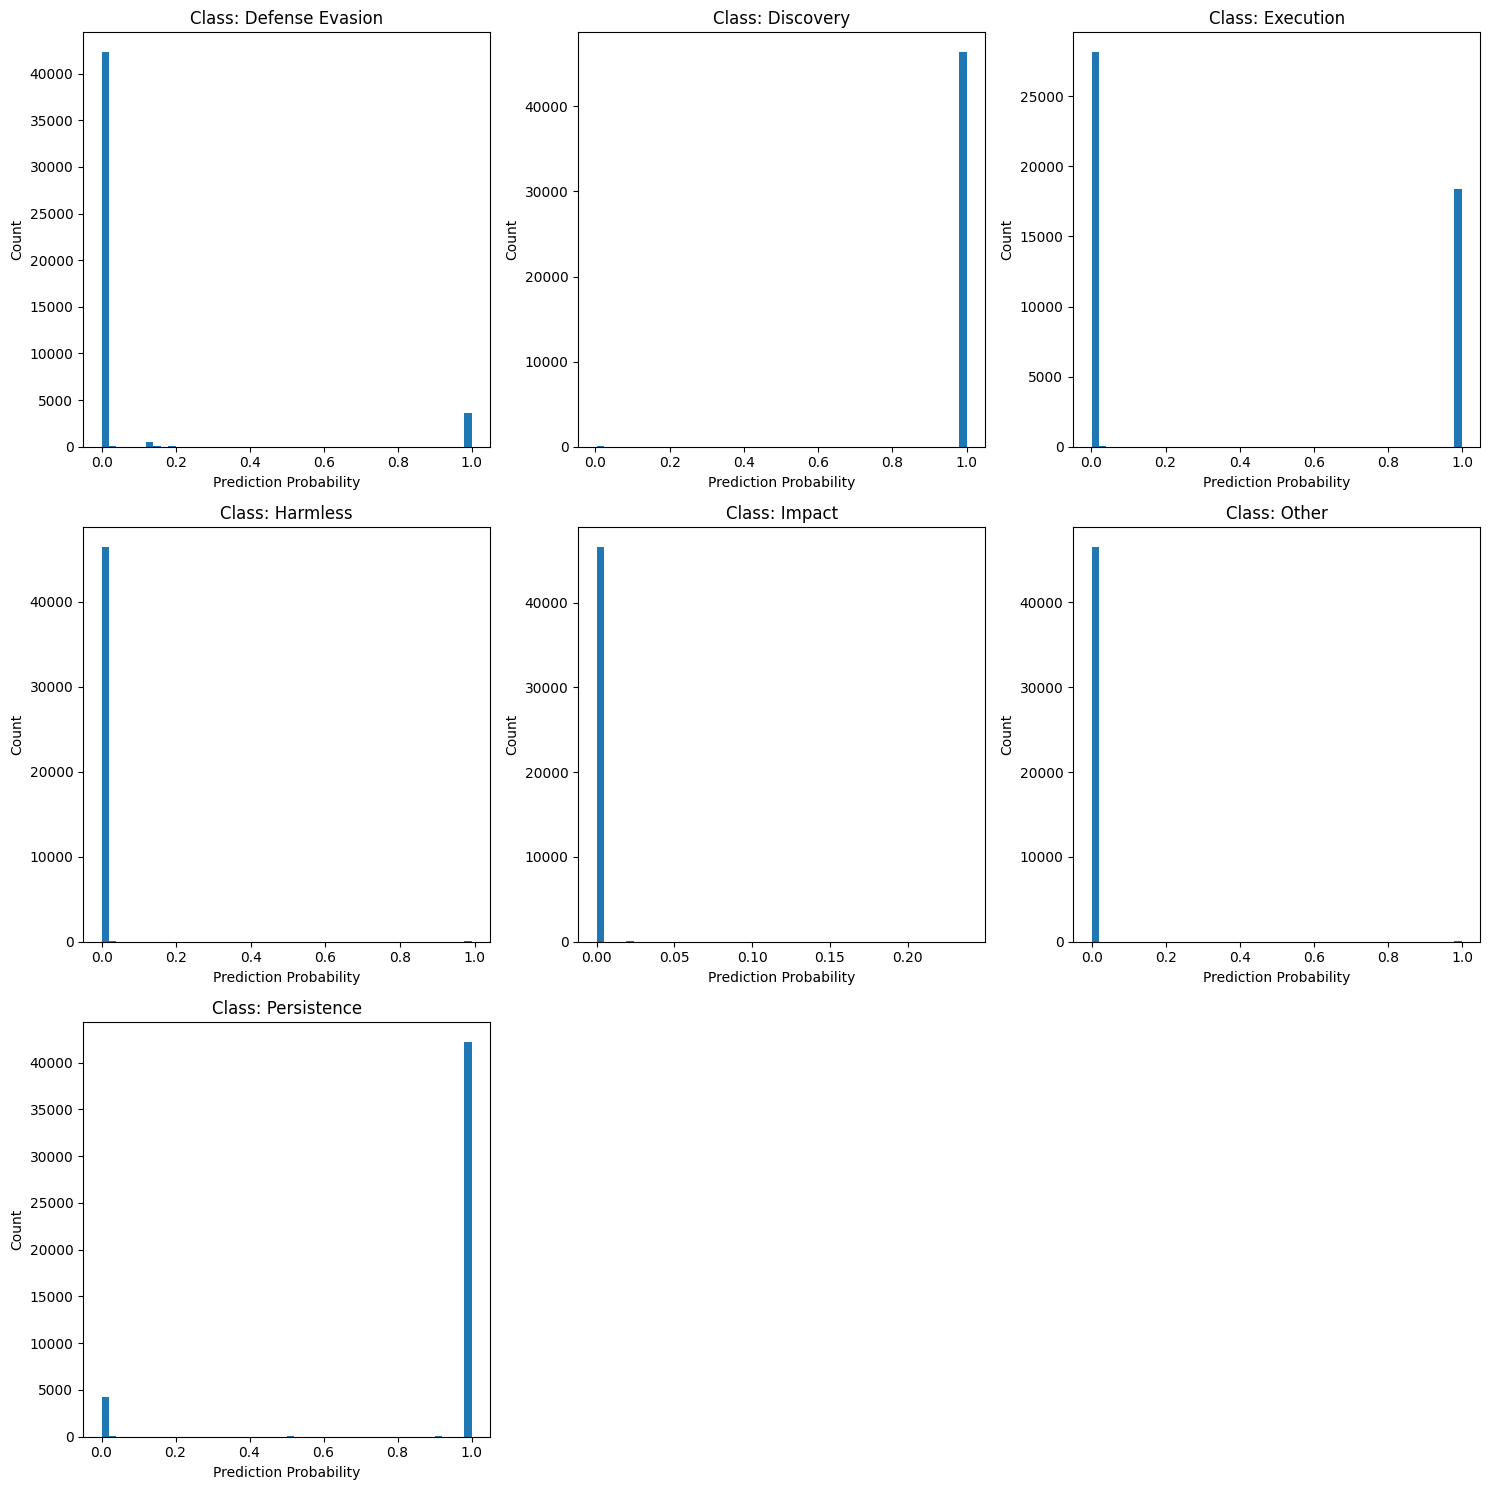

Overwriting file: '../results/figures/plots/section4/probability_histograms.png'
Plot saved successfully at: '../results/figures/plots/section4/probability_histograms.png'


<Figure size 640x480 with 0 Axes>

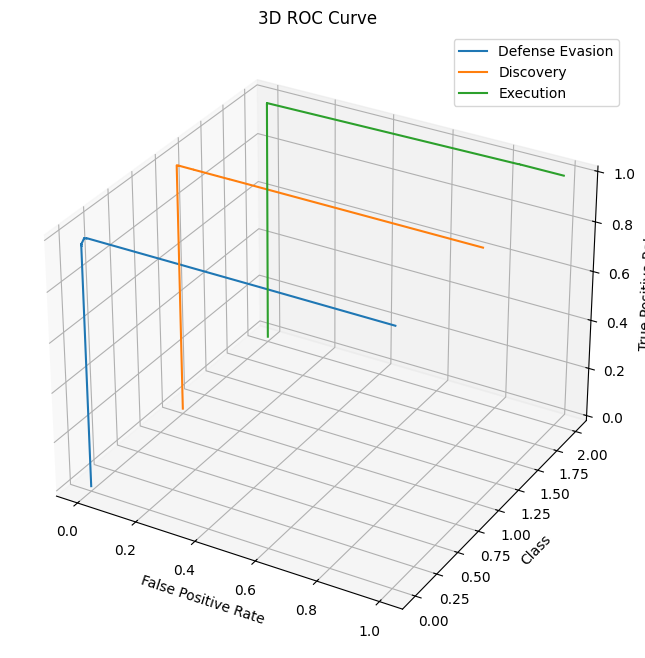

Overwriting file: '../results/figures/plots/section4/3d_roc_curve.png'
Plot saved successfully at: '../results/figures/plots/section4/3d_roc_curve.png'


<Figure size 640x480 with 0 Axes>

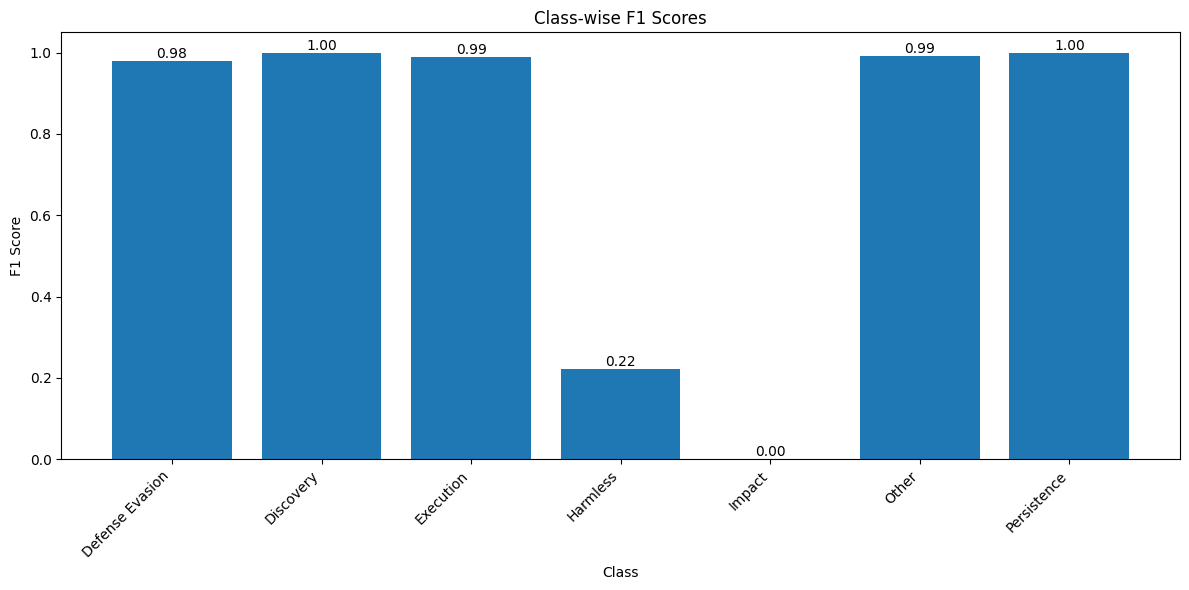

Overwriting file: '../results/figures/plots/section4/f1_scores.png'
Plot saved successfully at: '../results/figures/plots/section4/f1_scores.png'


<Figure size 640x480 with 0 Axes>

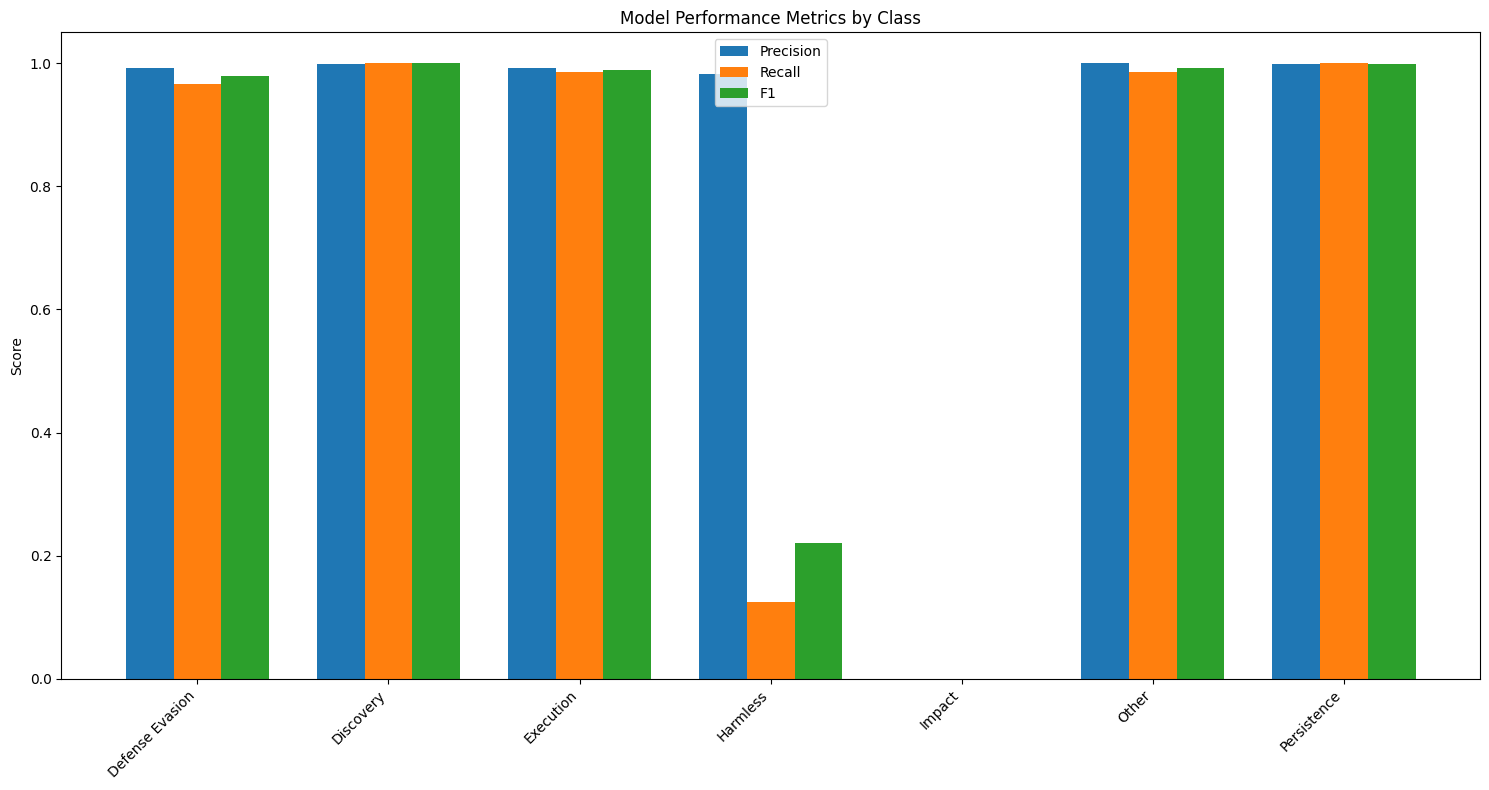

Overwriting file: '../results/figures/plots/section4/performance_metrics.png'
Plot saved successfully at: '../results/figures/plots/section4/performance_metrics.png'


<Figure size 640x480 with 0 Axes>

In [9]:
y_true = model_evaluation['true_labels']
y_pred_probs = model_evaluation['predicted_probabilities']
y_pred_probs_per_epoch = model_evaluation['probabilities_per_epoch']
train_losses = model_evaluation['train_losses']
val_losses = model_evaluation['val_losses']
class_names = mlb.classes_  # from MultiLabelBinarizer

# Generate and save all plots using plot_and_save
plots_to_generate = [

    {
        "func": plot_loss_curve,
        "args": {"train_losses": train_losses, "val_losses": val_losses},
        "filename": "loss_curves"
    },
    {
        "func": plot_roc_curves,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "roc_curves"
    },
    {
        "func": plot_pr_curves,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "precision_recall_curves"
    },
    {
        "func": plot_prob_histograms,
        "args": {"y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "probability_histograms"
    },
    {
        "func": plot_3d_roc,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "3d_roc_curve"
    },
    {
        "func": plot_f1_scores,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "f1_scores"
    },
    {
        "func": plot_performance_metrics,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "performance_metrics"
    },
]

# Generate and save each plot
for plot in plots_to_generate:
    plot_and_save(
        plot_func=plot["func"],
        plot_args=plot["args"],
        directory=plot_directory,
        filename=plot["filename"],
        filetype="png",
        overwrite=global_overwrite,
        show_plot=True  # Set to False if you don't want to display plots in the notebook
    )

# Functions To Reuse The Model In Future

In [21]:
# Recreate the model
bert_model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomBERTModel(bert_model, num_labels=y.shape[1])
model.to(device)

# Load the model weights
model.load_state_dict(torch.load("../data/Model/final_model.pth"))

# Optionally, if you saved the optimizer state, you can load that too
optimizer.load_state_dict(torch.load("../data/Model/optimizer.pth"))

# If you saved a checkpoint, you can load it as follows:
checkpoint = torch.load("../data/Model/checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_list = checkpoint['train_loss']
val_loss_list = checkpoint['val_loss']

/tmp/ipykernel_4165/2520426615.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../data/Model/final_model.pth"))
/tmp/ipykernel_4165/25

In [6]:
with open("../data/Model/model_evaluation.pkl", "rb") as f:
    model_evaluation = pickle.load(f)